In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [2]:
# Lendo o arquivo com o delimitador correto e codificação
df = pd.read_csv("https://datalaketech4.blob.core.windows.net/dados-ipea/cotacao_petroleo_ipea.csv", encoding="ISO-8859-1", delimiter=";", decimal=",")

In [3]:
df.head()

,data,preco
0,01/01/2015,55.27
1,02/01/2015,57.86
2,03/01/2015,55.60
3,04/01/2015,55.27
4,05/01/2015,55.27


In [4]:
df.shape

(3024, 2)

In [5]:
#Ajuste na data 
df.columns = df.columns.str.strip() 
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y') 

In [6]:
#Exibindo primeiras linhas 
print(df.head())

        data  preco
0 2015-01-01  55.27
1 2015-01-02  57.86
2 2015-01-03  55.60
3 2015-01-04  55.27
4 2015-01-05  55.27


In [7]:
#Tratando dados 
print(df.isnull().sum())  # Contar valores nulos
df.dropna(inplace=True)  # Remover se necessário

data     0
preco    0
dtype: int64


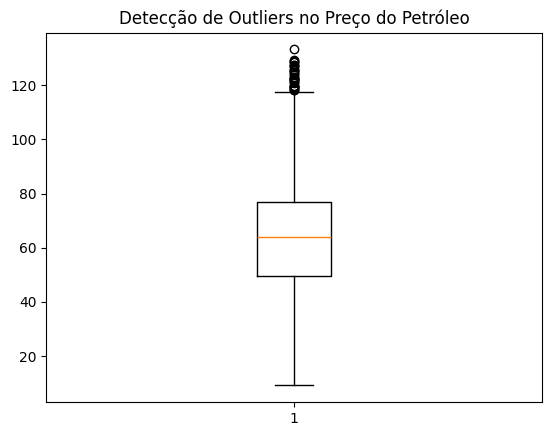

In [8]:
#Verificar e remover outliers
plt.boxplot(df['preco'])
plt.title("Detecção de Outliers no Preço do Petróleo")
plt.show()

In [9]:
# Calcular o IQR para detectar outliers
Q1 = df['preco'].quantile(0.25)
Q3 = df['preco'].quantile(0.75)
IQR = Q3 - Q1

In [10]:
# Definir limites para valores aceitáveis
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

In [11]:
# Filtrar outliers
df_sem_outliers = df[(df['preco'] >= limite_inferior) & (df['preco'] <= limite_superior)]

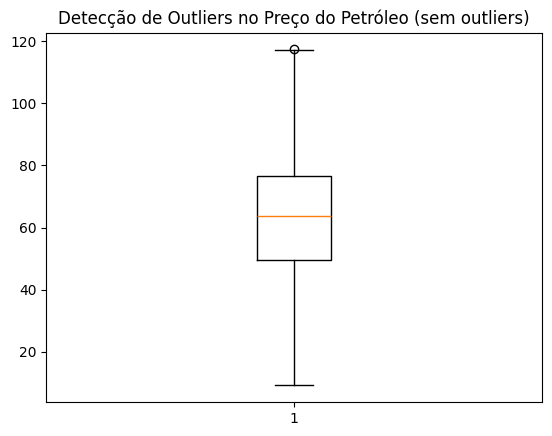

In [12]:
# Exibir gráfico novamente após a remoção dos outliers
plt.boxplot(df_sem_outliers['preco'])
plt.title("Detecção de Outliers no Preço do Petróleo (sem outliers)")
plt.show()


In [13]:
#Removendo valores 
df = df[df['preco'] < df['preco'].quantile(0.99)]  # Exemplo de remoção de outliers acima do percentil 99

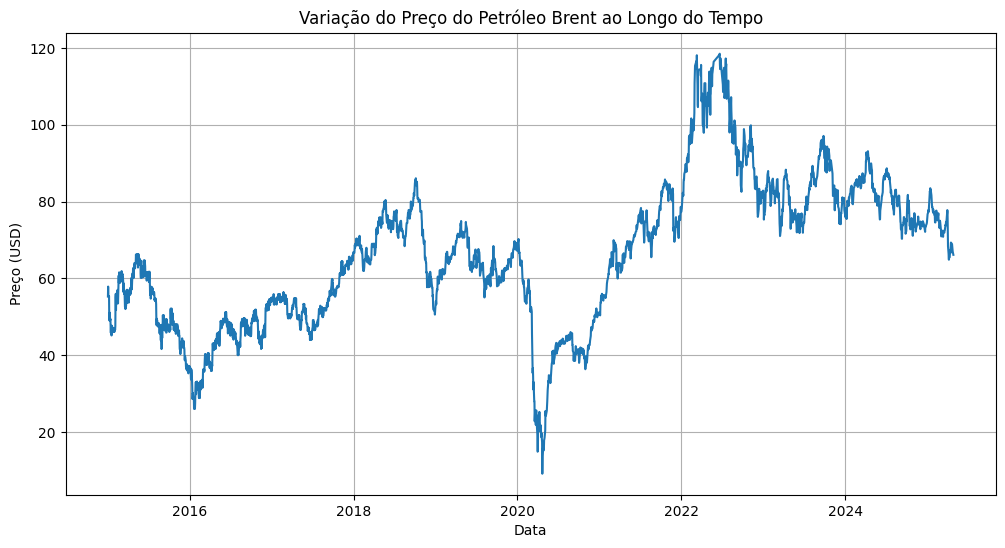

In [14]:
#Evolução do preço ao longo do tempo
plt.figure(figsize=(12,6))
sns.lineplot(x=df['data'], y=df['preco'])
plt.title("Variação do Preço do Petróleo Brent ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Preço (USD)")
plt.grid()
plt.show()

In [15]:
#Estatísticas descritivas para entender a distribuição dos preços
print(df['preco'].describe())

count    2993.000000
mean       64.096452
std        18.076723
min         9.120000
25%        49.460000
50%        63.620000
75%        76.680000
max       118.510000
Name: preco, dtype: float64


In [16]:
#Componentes sazonais
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month
df['dia_da_semana'] = df['data'].dt.dayofweek  # Segunda = 0, Domingo = 6

In [17]:
#Médias móveis para suavizar oscilações
df['media_movel_30'] = df['preco'].rolling(window=30).mean()

In [18]:
# Criando uma variável de lag de 1 dia
df['preco_lag_1'] = df['preco'].shift(1)

In [19]:
# Calculando a variação percentual
df['variacao_percentual'] = df['preco'].pct_change() * 100

In [20]:
# Normalizando os preços
scaler = StandardScaler()
df['preco_normalizado'] = scaler.fit_transform(df[['preco']])

In [21]:
# Calculando o logaritmo do preço
df['preco_log'] = np.log(df['preco'])

In [22]:
# Preenchendo os valores NaN
df['media_movel_30'] = df['media_movel_30'].fillna(df['media_movel_30'].mean())
df['variacao_percentual'] = df['variacao_percentual'].fillna(df['variacao_percentual'].mean())


In [23]:
# Verificando ajuste
print(df.head())

        data  preco   ano  mes  dia_da_semana  media_movel_30  preco_lag_1  \
0 2015-01-01  55.27  2015    1              3       64.136741          NaN   
1 2015-01-02  57.86  2015    1              4       64.136741        55.27   
2 2015-01-03  55.60  2015    1              5       64.136741        57.86   
3 2015-01-04  55.27  2015    1              6       64.136741        55.60   
4 2015-01-05  55.27  2015    1              0       64.136741        55.27   

   variacao_percentual  preco_normalizado  preco_log  
0             0.053449          -0.488359   4.012230  
1             4.686086          -0.345057   4.058026  
2            -3.905980          -0.470100   4.018183  
3            -0.593525          -0.488359   4.012230  
4             0.000000          -0.488359   4.012230  


In [24]:
# Verificando a correlação entre as variáveis
print(df.corr())

                         data     preco       ano       mes  dia_da_semana  \
data                 1.000000  0.667525  0.995362  0.037881      -0.229183   
preco                0.667525  1.000000  0.665912  0.011350      -0.147431   
ano                  0.995362  0.665912  1.000000 -0.058098      -0.229426   
mes                  0.037881  0.011350 -0.058098  1.000000       0.004483   
dia_da_semana       -0.229183 -0.147431 -0.229426  0.004483       1.000000   
media_movel_30       0.672663  0.967510  0.669156  0.030838      -0.146555   
preco_lag_1          0.667868  0.996351  0.666045  0.013030      -0.149093   
variacao_percentual -0.002707  0.017612 -0.001198 -0.014780       0.016100   
preco_normalizado    0.667525  1.000000  0.665912  0.011350      -0.147431   
preco_log            0.610126  0.974036  0.606570  0.032518      -0.129552   

                     media_movel_30  preco_lag_1  variacao_percentual  \
data                       0.672663     0.667868            -0.00270

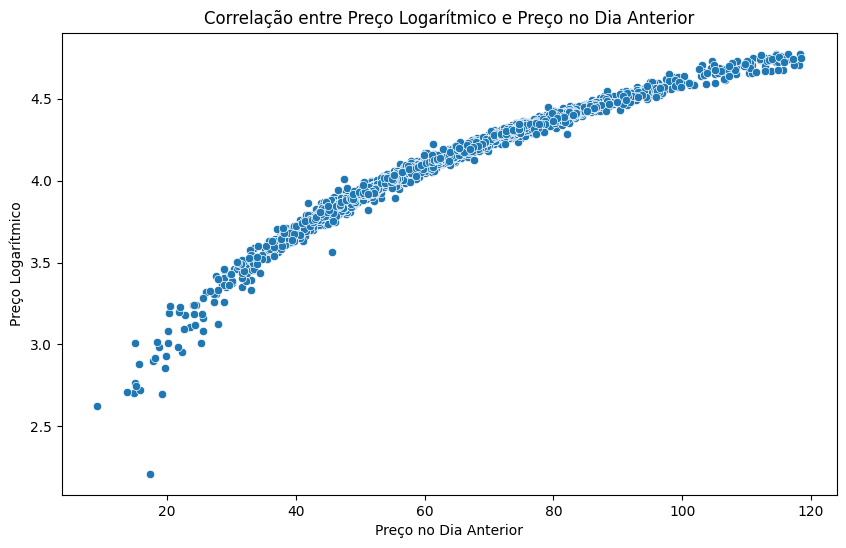

In [25]:
# Gráfico de dispersão entre preço no dia anterior e preço logarítmico
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['preco_lag_1'], y=df['preco_log'])
plt.title('Correlação entre Preço Logarítmico e Preço no Dia Anterior')
plt.xlabel('Preço no Dia Anterior')
plt.ylabel('Preço Logarítmico')
plt.show()

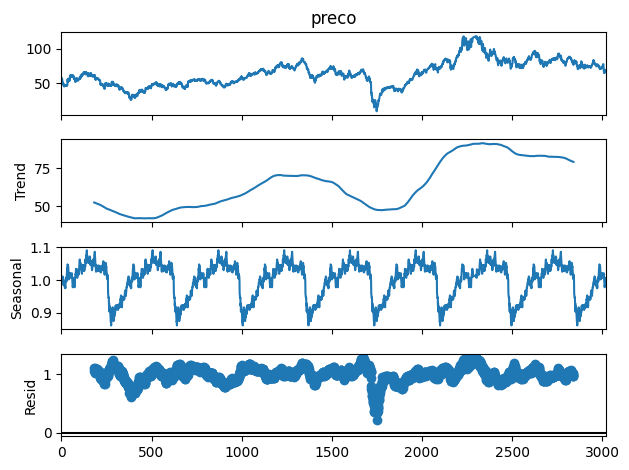

In [26]:
# Decomposição da série temporal
decomposicao = seasonal_decompose(df['preco'], model='multiplicative', period=365)
decomposicao.plot()
plt.show()

In [27]:
# Teste de Dickey-Fuller para verificar estacionariedade
result = adfuller(df['preco'])
print(f'Estatística ADF: {result[0]}')
print(f'p-valor: {result[1]}')
print(f'Número de lags: {result[2]}')
print(f'Número de observações: {result[3]}')
valores_criticos = result[4]

print("Valores críticos:")
for nivel, valor in valores_criticos.items():
    print(f"  {nivel}: {valor:.3f}")

Estatística ADF: -2.1848431663361776
p-valor: 0.21179243032489586
Número de lags: 8
Número de observações: 2984
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567


In [28]:
df_serie = df.loc[:, ['data', 'preco']]

In [29]:
df_serie = df_serie.set_index("data")

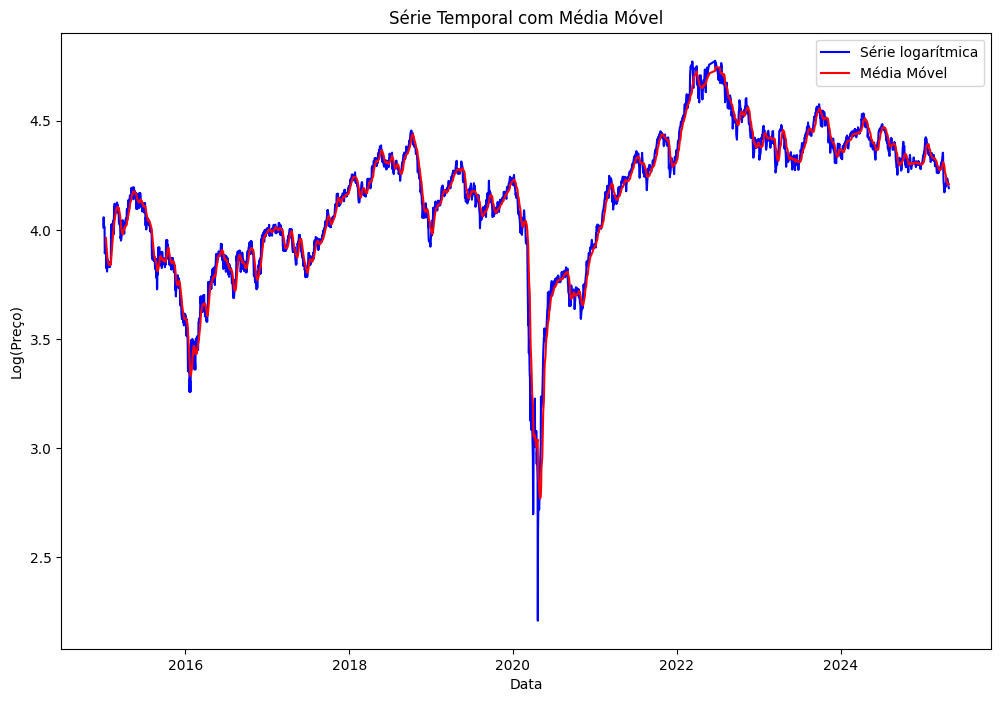

In [30]:
df_serie_log = np.log(df_serie)
ma_log = df_serie_log.rolling(window=12).mean()
df_series_log = df_serie_log.dropna()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_serie_log, label='Série logarítmica', color='blue')
ax.plot(ma_log, label='Média Móvel', color='red')
ax.set_title('Série Temporal com Média Móvel')
ax.set_xlabel('Data')
ax.set_ylabel('Log(Preço)')
ax.legend()

In [31]:
# Teste de Dickey-Fuller para verificar estacionariedade
result = adfuller(df_serie_log['preco'])
print(f'Estatística ADF: {result[0]}')
print(f'p-valor: {result[1]}')
print(f'Número de lags: {result[2]}')
print(f'Número de observações: {result[3]}')
valores_criticos = result[4]

print("Valores críticos:")
for nivel, valor in valores_criticos.items():
    print(f"  {nivel}: {valor:.3f}")

Estatística ADF: -3.16031164592789
p-valor: 0.022400034084478975
Número de lags: 27
Número de observações: 2965
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567


In [32]:
# df_series_sub = (df_series_log - ma_log).dropna()
# ma_sub = df_series_sub.rolling(window=12).mean()
# std_sub = df_series_sub.rolling(window=12).std()
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(df_series_sub, label='Série Subtraída', color='blue')
# ax.plot(ma_sub, label='Média Móvel Subtraída', color='red')
# ax.plot(std_sub, label='Desvio Padrão', color='green')
# ax.set_title('Série Temporal Subtraída com Média Móvel')
# ax.set_xlabel('Data')
# ax.set_ylabel('Log(Preço)')
# ax.legend()


In [33]:
# # Teste de Dickey-Fuller para verificar estacionariedade
# result = adfuller(df_series_sub['preco'])
# print(f'Estatística ADF: {result[0]}')
# print(f'p-valor: {result[1]}')
# print(f'Número de lags: {result[2]}')
# print(f'Número de observações: {result[3]}')
# valores_criticos = result[4]

# print("Valores críticos:")
# for nivel, valor in valores_criticos.items():
#     print(f"  {nivel}: {valor:.3f}")

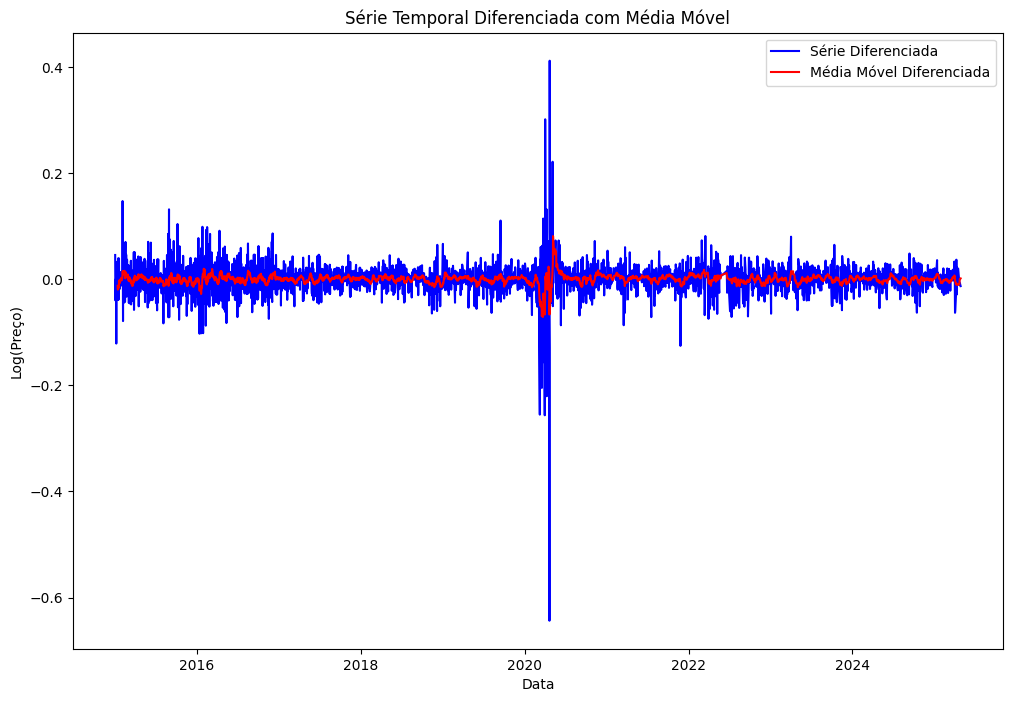

In [34]:
df_serie_diff = df_serie_log.diff().dropna()
ma_diff = df_serie_diff.rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_serie_diff, label='Série Diferenciada', color='blue')
ax.plot(ma_diff, label='Média Móvel Diferenciada', color='red')
ax.set_title('Série Temporal Diferenciada com Média Móvel')
ax.set_xlabel('Data')
ax.set_ylabel('Log(Preço)')
ax.legend()

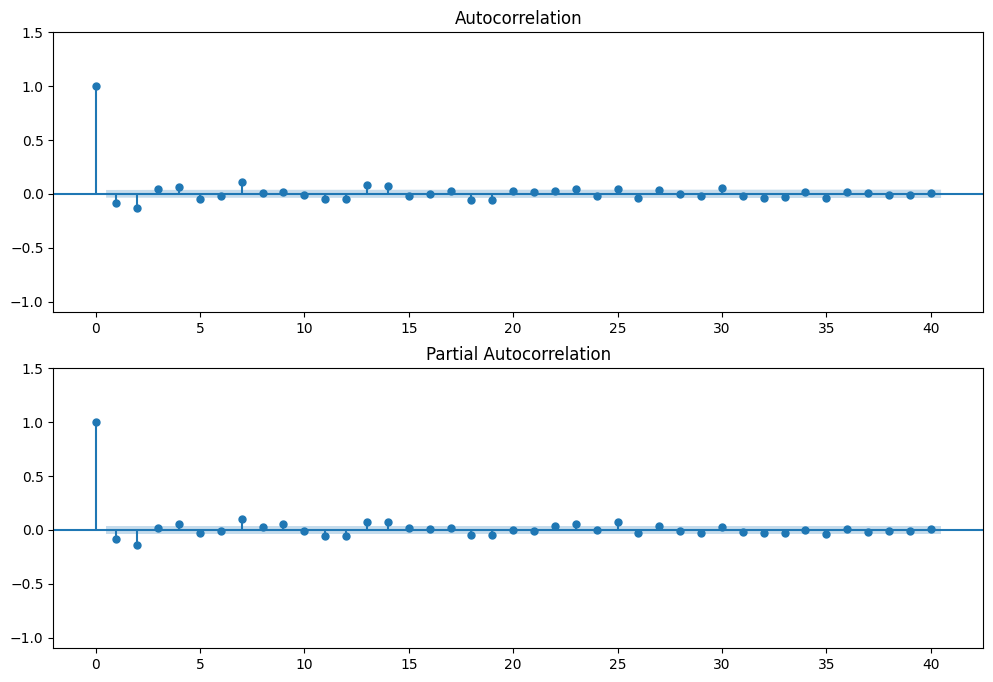

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_serie_diff['preco'], lags=40, ax=ax1)
plot_pacf(df_serie_diff['preco'], lags=40, ax=ax2)
ax1.set_ylim(-1.1, 1.5)
ax2.set_ylim(-1.1, 1.5)
plt.show()

In [36]:
# Teste de Dickey-Fuller para verificar estacionariedade
result = adfuller(df_serie_diff['preco'])
print(f'Estatística ADF: {result[0]}')
print(f'p-valor: {result[1]}')
print(f'Número de lags: {result[2]}')
print(f'Número de observações: {result[3]}')
valores_criticos = result[4]

print("Valores críticos:")
for nivel, valor in valores_criticos.items():
    print(f"  {nivel}: {valor:.3f}")

Estatística ADF: -8.978143337779201
p-valor: 7.43485735869157e-15
Número de lags: 26
Número de observações: 2965
Valores críticos:
  1%: -3.433
  5%: -2.863
  10%: -2.567


In [ ]:
# Supondo que df_series seja sua série de preço em log
modelo_auto = auto_arima(
    df_serie_diff,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    d=1,                  # Diferenciação não sazonal
    start_P=0, seasonal=True, m=365,  # m=365 para sazonalidade anual
    D=1, max_P=2, max_Q=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Ver melhores parâmetros
print(modelo_auto.summary())


Performing stepwise search to minimize aic


c:\Users\Mathw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Mathw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 

#### P,D,Q Order = (1,1,0)